<a href="https://colab.research.google.com/github/DorAzaria/Voice-Emotion-Recognition/blob/main/train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/data/')

Drive already mounted at /content/data/; to attempt to forcibly remount, call drive.mount("/content/data/", force_remount=True).


# **IMPORTS**
---

In [2]:
%%capture

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import pickle
import numpy as np
import pandas as pd
import os
import datetime
import torchaudio
import matplotlib.pyplot as plt
from numpy import mat
np.set_printoptions(suppress=True)

!sudo apt-get install libportaudio2
!sudo apt-get install python-scipy

!pip install sounddevice
!pip install scipy

import sounddevice
from scipy.io.wavfile import write

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
classes = {0: 'positive', 1:'neutral', 2:'negative'}

# **PREPROCESS**

---



In [3]:
class Data:

    def __init__(self):
        file_handler = open('/content/data/MyDrive/dl/dataset5.pth', 'rb')
        self.data = pickle.load(file_handler)
        x_dataset = [embedding[1] for embedding in self.data]
        y_dataset = [label[2] for label in self.data]
        self.distrib = [0, 0, 0]
        self.weights = [0, 0, 0]

        #[70, 15, 15]
        train_x, rem_x, train_y, rem_y = train_test_split(np.array(x_dataset), np.array(y_dataset), train_size=0.80) 
        valid_x, test_x, valid_y, test_y = train_test_split(rem_x, rem_y, test_size=0.5)

        for num in train_y:
          self.distrib[num] += 1

        max_value = max(self.distrib)

        for i in range(3):
          self.weights[i] = max_value / self.distrib[i]

        self.train_x = torch.from_numpy(train_x)
        self.train_y = torch.from_numpy(train_y)
        torch_train = TensorDataset(self.train_x, self.train_y)

        self.valid_x = torch.from_numpy(valid_x)
        self.valid_y = torch.from_numpy(valid_y)
        torch_valid = TensorDataset(self.valid_x, self.valid_y)
        
        self.test_x = torch.from_numpy(test_x)
        self.test_y = torch.from_numpy(test_y)
        torch_test = TensorDataset(self.test_x, self.test_y)
        
        self.train_loader = DataLoader(torch_train, batch_size=32, drop_last=True, shuffle=True)
        self.valid_loader = DataLoader(torch_valid, batch_size=32, drop_last=True, shuffle=True)
        self.test_loader = DataLoader(torch_test, batch_size=32, drop_last=True, shuffle=False)

**PLOT**

In [ ]:
def my_plot(train_acc, test_acc, train_loss):
    epochs_x_axis = np.linspace(1, len(train_acc), len(train_acc)).astype(int)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    axes[0].plot(epochs_x_axis, train_acc)
    axes[0].plot(epochs_x_axis, test_acc)
    axes[0].set_ylabel("Accuracy")
    axes[0].set_xlabel("epochs")
    axes[0].legend(['train', 'test'])
    

    axes[1].plot(epochs_x_axis, train_loss)
    axes[1].set_ylabel("Training loss")
    axes[1].set_xlabel("epochs")
    fig.tight_layout()

In [4]:
def plotEarlyStopping(train_loss, valid_loss, file_png_name):
  epochs_x_axis = np.linspace(1, len(train_loss), len(train_loss)).astype(int)
  plt.plot(epochs_x_axis, train_loss)
  plt.plot(epochs_x_axis, valid_loss)
  plt.title('Train VS Valid Loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train loss', 'validation loss'], loc='upper left')
  plt.savefig(file_png_name)

# **Model**

1, 149, 32
---



In [5]:
DROP_OUT = 0.8
NUM_OF_CLASSES = 3

class ConvNet(nn.Module):

    def __init__(self):
        super().__init__()

        # Hyper parameters
        self.epochs = 300
        self.batch_size = 32
        self.learning_rate = 0.0001

        # Model Architecture
        self.first_conv = nn.Conv2d(1, 96, kernel_size=(5, 5), padding=1) # (96, 147, 30)
        self.first_bn = nn.BatchNorm2d(96)
        self.first_polling = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2)) # (96, 73, 14)

        self.second_conv = nn.Conv2d(96, 256, kernel_size=(5, 5), padding=1) # (256, 71, 12)
        self.second_bn = nn.BatchNorm2d(256)
        self.second_polling = nn.MaxPool2d(kernel_size=(3, 3), stride=(1, 1)) # (256, 69, 10)

        self.third_conv = nn.Conv2d(256, 384, kernel_size=(3, 3), padding=1) # (384, 69, 10 )
        self.third_bn = nn.BatchNorm2d(384)

        self.forth_conv = nn.Conv2d(384, 256, kernel_size=(3, 3), padding=1) # (256, 69, 10)
        self.forth_bn = nn.BatchNorm2d(256)

        self.fifth_conv = nn.Conv2d(256, 256, kernel_size=(3, 3), padding=1) # (256, 69, 10)
        self.fifth_bn = nn.BatchNorm2d(256)
        self.fifth_polling = nn.MaxPool2d(kernel_size=(2, 2), stride=(1, 1)) # (256, 68, 9)

        self.sixth_conv = nn.Conv2d(256, 64, kernel_size=(2, 2), padding=1) # (64, 69, 10)

        self.seventh_conv = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1) # (64, 69, 10)
        self.seventh_polling = nn.MaxPool2d(kernel_size=(2,2), stride=(2, 2)) # (64, 34, 5)

        self.eighth_conv = nn.Conv2d(64, 32, kernel_size=(3,3), padding=1) # (32, 34, 5)
        self.first_drop = nn.Dropout(p=DROP_OUT)

        self.avg_polling = nn.AdaptiveAvgPool2d((1, 1))
        self.first_dense = nn.Linear(32, 1024)
        self.second_drop = nn.Dropout(p=DROP_OUT)

        self.second_dense = nn.Linear(1024, NUM_OF_CLASSES)

    def forward(self, X):
        x = nn.ReLU()(self.first_conv(X))
        x = self.first_bn(x)
        x = self.first_polling(x)

        x = nn.ReLU()(self.second_conv(x))
        x = self.second_bn(x)
        x = self.second_polling(x)

        x = nn.ReLU()(self.third_conv(x))
        x = self.third_bn(x)

        x = nn.ReLU()(self.forth_conv(x))
        x = self.forth_bn(x)

        x = nn.ReLU()(self.fifth_conv(x))
        x = self.fifth_bn(x)
        x = self.fifth_polling(x)

        x = nn.ReLU()(self.sixth_conv(x))

        x = nn.ReLU()(self.seventh_conv(x))
        x = self.seventh_polling(x)

        x = nn.ReLU()(self.eighth_conv(x))

        x = self.first_drop(x)
        x = self.avg_polling(x)

        x = x.view(-1, x.shape[1])  # output channel for flatten before entering the dense layer

        x = nn.ReLU()(self.first_dense(x))
        x = self.second_drop(x)

        x = self.second_dense(x)
        y = nn.LogSoftmax(dim=1)(x)  # consider using Log-Softmax

        return y

    def get_epochs(self):
        return self.epochs

    def get_learning_rate(self):
        return self.learning_rate

    def get_batch_size(self):
        return self.batch_size

In [6]:
def accuracy(predictions, labels):
    classes = torch.argmax(predictions, dim=1)
    return torch.mean((classes == labels).float()).to('cpu')

# **TEST**

---



In [7]:
def test(convnet_model, dataset):
    results = []
    test_batch_acc = []

    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        n_class_correct = [0 for i in range(3)]
        n_class_samples = [0 for i in range(3)]
        
        n_class = [0 for i in range(len(dataset.test_y))]
        j = 0
        
        for embedding, labels in dataset.test_loader:
            
            embedding = embedding.type(torch.FloatTensor)
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)
            embedding = embedding.to(device)
            outputs = convnet_model(embedding)

            # max returns (value ,index)
            _, predicted = torch.max(outputs, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

            test_batch_acc.append(accuracy(outputs, labels))

            for i in range(convnet_model.batch_size):
                label = labels[i]
                pred = predicted[i]
                if label == pred:
                    n_class_correct[label] += 1
                n_class_samples[label] += 1
                n_class[j] = pred.view(-1).detach().cpu().numpy()[0]
                j += 1
        returned_acc = sum(test_batch_acc)/len(test_batch_acc)

        acc = 100.0 * n_correct / n_samples
        results.append(f'Accuracy of the network: {acc} %')

        for i in range(3):
            acc = 100.0 * n_class_correct[i] / n_class_samples[i]
            results.append(f'Accuracy of {classes[i]}: {acc} %')
        
        return n_class, results, returned_acc

# **Validation**

---



In [8]:
def validation(convnet_model, dataset, loss_function):
    # Settings
    model.eval()
    loss_total = 0

    # Test validation data
    with torch.no_grad():
        for embedding, labels in dataset.valid_loader:
            embedding = embedding.type(torch.FloatTensor)
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)
            embedding = embedding.to(device)

            outputs = convnet_model(embedding)
            loss = loss_function(outputs, labels)
            loss_total += loss.item()

    return loss_total / len(dataset.valid_loader)


# **Train**
---


In [12]:
def train_model(convnet_model, dataset):
    save_counter=0
    acc_vals_train = []
    loss_vals_train = []
    loss_valid = []
    acc_vals_test = []
    optimizer = torch.optim.Adam(convnet_model.parameters(), lr=convnet_model.learning_rate, weight_decay=1e-4)

    # [3304, 2895, 9004] --> 15k examples
    # [1184, 688, 2363] --> 4235 examples
    # criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor([2.72518159806, 3.11018998273, 1])).to(device)
    criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor([1.99, 3.0, 1.0])).to(device)
    
    n_total_steps = len(dataset.train_loader)

    # Early stopping
    the_last_loss = 100
    patience = 2
    trigger_times = 0

    for epoch in range(convnet_model.get_epochs()):

        convnet_model.train()
        epoch_acc = []
        epoch_loss = []

        for i, (embedding, labels) in enumerate(dataset.train_loader):

            embedding = embedding.type(torch.FloatTensor)
            labels = labels.type(torch.LongTensor)
        
            labels = labels.to(device)
            embedding = embedding.to(device)

            # Forward pass
            outputs = convnet_model.forward(embedding)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_acc.append(accuracy(outputs, labels))
            epoch_loss.append(loss.item())
            if i == 90:
                print(f'Epoch [{epoch + 1}/{convnet_model.epochs}], Loss: {loss.item():.4f}')
                
        acc_vals_train.append(sum(epoch_acc)/len(epoch_acc))
        loss_vals_train.append(sum(epoch_loss)/len(epoch_loss))

        _ , _, test_acc = test(convnet_model, dataset)
        acc_vals_test.append(test_acc)

        #### EARLY STOPPING ~~~~~~~~~~~~~~~~~~~
        the_current_loss = validation(convnet_model, dataset, criterion)
        loss_valid.append(the_current_loss)

        if the_current_loss > the_last_loss:
            trigger_times += 1
            print('trigger times:', trigger_times)
            # if loss_vals_train[-1] < 0.7:
            torch.save(cnn, f"/content/model{save_counter}.pth")
            plotEarlyStopping(loss_vals_train,loss_valid, f"/content/model{save_counter}.png")
            print(f'saved model{save_counter}.pth')
            save_counter += 1
            if trigger_times >= patience:
                print('Early stopping!')
                break

        else:
            trigger_times = 0

        the_last_loss = the_current_loss
        ##### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


    # my_plot(acc_vals_train, acc_vals_test, loss_vals_train)
    # plotEarlyStopping(loss_vals_train,loss_valid)

# **Main**

---


## NORM AND INFERENCE

In [10]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
model = bundle.get_model().to(device)


def inference(file_name):
    SAMPLE_RATE = 16000
    waveform, sample_rate = torchaudio.load(filepath=file_name,  num_frames=SAMPLE_RATE * 3)
    # waveform = waveform.view(1, 96000)
    waveform = waveform.to(device)
    
    if (len(waveform[0]) < 48000):
        print(f'less than 3 seconds: {file_name}')

    if sample_rate != bundle.sample_rate:
        waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

    with torch.inference_mode():
        embedding, _ = model(waveform)

    return embedding.unsqueeze(0)


def Norm(X):
    embedding = X.detach().cpu().numpy()
    for i in range(len(embedding)):
        mlist = embedding[0][i]
        embedding[0][i] = 2 * (mlist - np.max(mlist)) / (np.max(mlist) - np.min(mlist)) + 1

    return torch.from_numpy(embedding).to(device)

## START TRAIN

---



Epoch [1/300], Loss: 1.0608
Epoch [2/300], Loss: 0.8407
Epoch [3/300], Loss: 0.6347
trigger times: 1
saved model0.pth
Epoch [4/300], Loss: 0.5130
Epoch [5/300], Loss: 0.7089
Epoch [6/300], Loss: 0.5510
Epoch [7/300], Loss: 0.3918
trigger times: 1
saved model1.pth
Epoch [8/300], Loss: 0.6387
Epoch [9/300], Loss: 0.3593
Epoch [10/300], Loss: 0.5058
trigger times: 1
saved model2.pth
Epoch [11/300], Loss: 0.5223
Epoch [12/300], Loss: 0.5793
trigger times: 1
saved model3.pth
Epoch [13/300], Loss: 0.3775
Epoch [14/300], Loss: 0.2988
Epoch [15/300], Loss: 0.4538
Epoch [16/300], Loss: 0.5056
trigger times: 1
saved model4.pth
Epoch [17/300], Loss: 0.3652
Epoch [18/300], Loss: 0.3458
trigger times: 1
saved model5.pth
Epoch [19/300], Loss: 0.2850
Epoch [20/300], Loss: 0.3989
Epoch [21/300], Loss: 0.5094
trigger times: 1
saved model6.pth
Epoch [22/300], Loss: 0.2842
trigger times: 2
saved model7.pth
Early stopping!


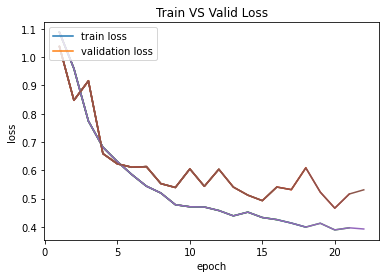

In [13]:
dataset = Data()
cnn = ConvNet()
cnn.to(device)
train_model(cnn, dataset)

In [85]:
print(dataset.distrib)
print(dataset.weights)

[822, 489, 1653]
[2.010948905109489, 3.3803680981595092, 1.0]


In [14]:
torch.save(cnn, "/content/data/MyDrive/dl/model207.pth")

In [48]:
model_import = torch.load("/content/model7.pth")

## START TEST


Accuracy of the network: 76.20192307692308 %

Accuracy of positive: 65.60693641618496 %

Accuracy of neutral: 71.14427860696517 %

Accuracy of negative: 82.88159771754636 %

---



In [49]:
n_class, results,  _ = test(model_import, dataset)

for text in results:
  print(text)

Accuracy of the network: 73.07692307692308 %
Accuracy of positive: 71.55963302752293 %
Accuracy of neutral: 77.94117647058823 %
Accuracy of negative: 72.38493723849372 %


[[ 79  11  20]
 [ 11  53   7]
 [ 41  29 173]]


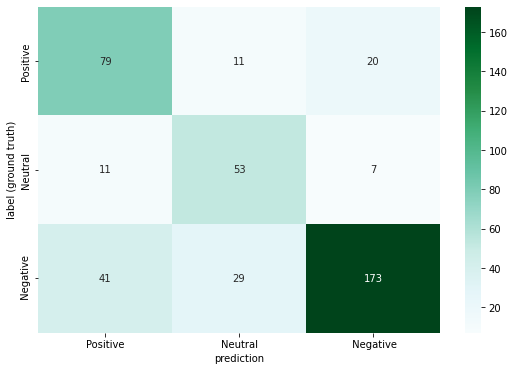

In [50]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Display the confusion matrix as a heatmap
arr = confusion_matrix(dataset.test_y.detach().cpu().numpy(), n_class)
class_names = ['Positive', 'Neutral', ' Negative']
print(arr)
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

## INFERENCE

---



In [16]:
def print_results(y):
  predict = [np.exp(c) for c in y]
  max = np.argmax(predict)
  print(f'Predicted: {classes[max].capitalize()}')
  print(f'Positive: {round(predict[0][0]*100, 4)}%')
  print(f'Neutral: {round(predict[0][1]*100, 4)}%')
  print(f'Negative: {round(predict[0][2]*100, 4)}%')

Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

In [17]:
# NEGATIVE TRUTH
inf_X = inference('/content/data/MyDrive/dl/ravdess/Actor_01/03-01-05-01-01-02-01.wav')
X = Norm(inf_X)
y = cnn.forward(X)
y = y.cpu().detach().numpy()
print_results(y)

Predicted: Negative
Positive: 0.6837%
Neutral: 0.0039%
Negative: 99.3124%


In [18]:
# NEUTRAL TRUTH
inf_X = inference('/content/data/MyDrive/dl/ravdess/Actor_10/03-01-01-01-02-02-10.wav')
X = Norm(inf_X)
y = cnn.forward(X)
y = y.cpu().detach().numpy()
print_results(y)

Predicted: Negative
Positive: 15.7768%
Neutral: 41.2873%
Negative: 42.9358%


In [21]:
# POSITIVE TRUTH
inf_X = inference('/content/data/MyDrive/dl/ravdess/Actor_08/03-01-03-01-02-02-08.wav')
X = Norm(inf_X)
y = cnn.forward(X)
y = y.cpu().detach().numpy()
print_results(y)

Predicted: Positive
Positive: 61.205%
Neutral: 0.1087%
Negative: 38.6864%
